In [6]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

In [7]:
df_tweets = pd.read_csv('Updated_dataset_with_full_text.csv')

In [8]:
df_tweets

,TweetID,Username,CreateDate,Biased,Keyword,Text
0,1232258532273090560,amit2nirvana,2020-02-25 10:58:23+00:00,0,Israel,The last 24 hours in Israel: https://t.co/0YNw...
1,1224025761092448257,NinjaAlex420,2020-02-02 17:44:17+00:00,0,Israel,@stranahan KnowMoreNews isn't confident enough...
2,1242382710561107969,SevenShepherd,2020-03-24 09:28:15+00:00,0,Israel,"""[Even] an heritage unto Israel his servant: f..."
3,1224677205306818561,MGSheikh8,2020-02-04 12:52:53+00:00,0,Israel,Opinion: No One in Israel Knew They Were Commi...
4,1214278369338109953,elianebis1,2020-01-06 20:11:38+00:00,0,Israel,https://t.co/LTB0zidzM9 When #TheCloudOfGod ap...
...,...,...,...,...,...,...
6936,1255850426899013632,TAG73957257,2020-04-30 13:24:09+00:00,1,ZioNazi,@JackieKane I'd never go back. ZioNazi managem...
6937,1234276923213303812,totalsatire,2020-03-02 00:38:44+00:00,1,ZioNazi,@JulianRoepcke The lovely Zionazi Djihad Julia...
6938,1240883925096030208,Futatimbo,2020-03-20 06:12:36+00:00,1,ZioNazi,@IvankaTrump A zionazists Jews.
6939,1241091821645844480,Futatimbo,2020-03-20 19:58:43+00:00,1,ZioNazi,"Mr. President, I this year you will lead the I..."


In [20]:
df_tweets.groupby(['Keyword','Biased']).count()

TweetID  Username  CreateDate  Text
Keyword Biased                                     
Israel  0          1321      1321        1321  1321
        1           203       203         203   203
Jews    0          4122      4122        4122  4122
        1           483       483         483   483
Kikes   0           186       186         186   186
        1            97        97          97    97
ZioNazi 0            62        62          62    62
        1           467       467         467   467

In [17]:
df_tweets.groupby('Username')['Text'].count().sort_values(ascending=False)

Username
theforeverman     38
plive_calmer      32
TheAesculapius    17
360CNN            15
RedSimpson3       12
                  ..
Mayeyala           1
MayerSimcha        1
MayaMayFly         1
Maxziken           1
zzxyxy             1
Name: Text, Length: 6374, dtype: int64

In [29]:
df_tweets.isnull().sum()

TweetID       0
Username      0
CreateDate    0
Biased        0
Keyword       0
Text          0
word_count    0
dtype: int64

In [21]:
import matplotlib.pyplot as plt

In [25]:
# WORD-COUNT
df_tweets['word_count'] = df_tweets['Text'].apply(lambda x: len(str(x).split()))
print(df_tweets[df_tweets['Biased']==1]['word_count'].mean()) #Disaster tweets
print(df_tweets[df_tweets['Biased']==0]['word_count'].mean()) #Non-Disaster tweets

25.0936
29.978914074855034


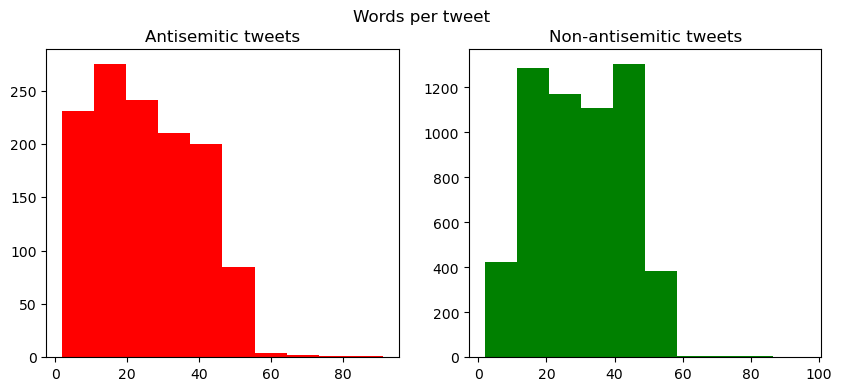

In [28]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_tweets[df_tweets['Biased']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Antisemitic tweets')
train_words=df_tweets[df_tweets['Biased']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-antisemitic tweets')
fig.suptitle('Words per tweet')
plt.show()

In [32]:
df_tweets['char_count'] = df_tweets['Text'].apply(lambda x: len(str(x)))
print(df_tweets[df_tweets['Biased']==1]['char_count'].mean()) #Disaster tweets
print(df_tweets[df_tweets['Biased']==0]['char_count'].mean()) #Non-Disaster tweets

169.9744
198.4008082937972


In [33]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [34]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_tweets['clean_text'] = df_tweets['Text'].apply(lambda x: finalpreprocess(x))
df_tweets.head()

,TweetID,Username,CreateDate,Biased,Keyword,Text,word_count,char_count,clean_text
0,1232258532273090560,amit2nirvana,2020-02-25 10:58:23+00:00,0,Israel,The last 24 hours in Israel: https://t.co/0YNw...,7,52,last hour israel https co ynwvmsyvl
1,1224025761092448257,NinjaAlex420,2020-02-02 17:44:17+00:00,0,Israel,@stranahan KnowMoreNews isn't confident enough...,15,120,stranahan knowmorenews confident enough debate...
2,1242382710561107969,SevenShepherd,2020-03-24 09:28:15+00:00,0,Israel,"""[Even] an heritage unto Israel his servant: f...",18,115,even heritage unto israel servant mercy endure...
3,1224677205306818561,MGSheikh8,2020-02-04 12:52:53+00:00,0,Israel,Opinion: No One in Israel Knew They Were Commi...,16,124,opinion one israel know commit massacre care n...
4,1214278369338109953,elianebis1,2020-01-06 20:11:38+00:00,0,Israel,https://t.co/LTB0zidzM9 When #TheCloudOfGod ap...,34,217,http co ltb zidzm thecloudofgod appear day mos...


In [35]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_tweets["clean_text"],df_tweets["Biased"],test_size=0.2,shuffle=True)
#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [46]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)
#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
            return self
    def transform(self, X):
            return np.array([
                np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                        or [np.zeros(self.dim)], axis=0)
                for words in X
            ])
# Tokenize the text data in df_tweets
df_tweets['clean_text_tok'] = [nltk.word_tokenize(i) for i in df_tweets['clean_text']]

# Instantiate and train the Word2Vec model
model = Word2Vec(df_tweets['clean_text_tok'], min_count=1)

# Create the Word2Vec dictionary
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

modelw = MeanEmbeddingVectorizer(w2v)
# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

In [44]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1137
           1       0.81      0.47      0.60       252

    accuracy                           0.88      1389
   macro avg       0.85      0.72      0.76      1389
weighted avg       0.88      0.88      0.87      1389

Confusion Matrix: [[1109   28]
 [ 133  119]]
AUC: 0.8345409110580615


In [48]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1137
           1       0.95      0.07      0.13       252

    accuracy                           0.83      1389
   macro avg       0.89      0.54      0.52      1389
weighted avg       0.85      0.83      0.77      1389

Confusion Matrix: [[1136    1]
 [ 234   18]]
AUC: 0.7925932906143988


In [49]:
df_new = pd.read_csv('analysed_cleaned_df3_with_country.csv')

In [50]:
df_new

,Unnamed: 0,type,date,url,text,user,user_url,user_location,followers,following,account_creation_date,tweet_likes,quotes,retweets,antisemitic_post,non_antisemitic_post,country
0,0,tweet,2023-10-23 10:00:02+00:00,https://twitter.com/ShaykhSulaiman/status/1716...,EXTREME CENSORSHIP - THESE SAME PEOPLE CRIED W...,ShaykhSulaiman,https://x.com/ShaykhSulaiman,UK,466037,433,10/23/2023,4286,51,1477,True,False,United Kingdom
1,1,tweet,2023-11-05 00:26:21+00:00,https://twitter.com/blackintheempir/status/172...,Zionism is racism and fascism on steroids,blackintheempir,https://x.com/blackintheempir,"Baltimore, MD",166044,22735,11/5/2023,2287,6,749,True,False,United States of America
2,2,tweet,2023-10-15 23:41:26+00:00,https://twitter.com/dancohen3000/status/171370...,Israeli “terrrorism expert” calls to carpet bo...,dancohen3000,https://x.com/dancohen3000,"Washington, DC",326535,2627,10/15/2023,748,33,406,True,False,United States of America
3,3,tweet,2023-11-04 04:58:06+00:00,https://twitter.com/meganshead/status/17206667...,Dear everyone who is frightened about rising a...,meganshead,https://x.com/meganshead,Cape Town,7647,2199,11/4/2023,315,7,97,True,False,South Africa
4,4,tweet,2023-10-27 23:46:41+00:00,https://twitter.com/NimaTavRood/status/1718051...,“Why are you pro-Palestine when you’re an athe...,NimaTavRood,https://x.com/NimaTavRood,Unknown,17184,4891,10/27/2023,165,3,25,False,True,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,1473,tweet,2024-03-14 15:30:54+00:00,https://twitter.com/NiohBerg/status/1768298767...,"From the River to the Sea, Palestine will neve...",NiohBerg,https://x.com/NiohBerg,Limbo,43244,1904,3/14/2024,4770,22,372,True,False,Unknown
1414,1474,tweet,2024-03-16 23:32:02+00:00,https://twitter.com/AgentP22/status/1769144625...,"Sounds very like ""From the river to the sea"".\...",AgentP22,https://x.com/AgentP22,United Kingdom,52479,4045,3/16/2024,1507,19,310,False,True,United Kingdom
1415,1475,tweet,2024-03-15 08:53:54+00:00,https://twitter.com/DaveAtherton20/status/1768...,"This is Hamas Leader Khaled Mashal, asked abou...",DaveAtherton20,https://x.com/DaveAtherton20,London,162270,44762,3/15/2024,131,11,84,False,True,United Kingdom
1416,1476,tweet,2024-03-29 15:56:03+00:00,https://twitter.com/BurninTRanch/status/177374...,Last night 3 Presidents descended on New York ...,BurninTRanch,https://x.com/BurninTRanch,Unknown,17078,14507,3/29/2024,84,2,30,False,True,Unknown


In [52]:
#Pre-processing the new dataset
df_new['clean_text'] = df_new['text'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_new['clean_text'] 
#converting words to numerical data using tf-idf
X_vector=tfidf_vectorizer.transform(X_test)
#use the best model to predict 'target' value for the new dataset 
y_predict = lr_tfidf.predict(X_vector)      
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_new['predict_prob']= y_prob
df_new['target']= y_predict
final=df_new[['clean_text','target','antisemitic_post']].reset_index(drop=True)


                                          clean_text  target antisemitic_post
0  extreme censorship people cry censorship covid...       0             True
1                     zionism racism fascism steroid       0             True
2  israeli terrrorism expert call carpet bomb gaz...       1             True
3  dear everyone frighten rise anti semitism best...       0             True
4  pro palestine youre atheist exactly im sociali...       0            False


In [53]:
final

,clean_text,target,antisemitic_post
0,extreme censorship people cry censorship covid...,0,True
1,zionism racism fascism steroid,0,True
2,israeli terrrorism expert call carpet bomb gaz...,1,True
3,dear everyone frighten rise anti semitism best...,0,True
4,pro palestine youre atheist exactly im sociali...,0,False
...,...,...,...
1413,river sea palestine never real http co llpbm l k,1,True
1414,sound like river sea say https co qfwbuc n c,0,False
1415,hamas leader khaled mashal ask state solution ...,0,False
1416,last night president descend new york city fun...,0,False


In [54]:
final['target'].value_counts()

target
0    1163
1     255
Name: count, dtype: int64

In [55]:
final['antisemitic_post'].value_counts()

antisemitic_post
False    933
True     464
Name: count, dtype: int64

In [ ]:
from bert_serving.client import BertClient

# make a connection with the BERT server using it's ip address; do not give any ip if same computer
bc = BertClient()
# get the embedding
embedding = bc.encode(["I love data science and analytics vidhya."])
# check the shape of embedding, it should be 1x768
print(embedding.shape)

In [2]:
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
import re
import time
import pickle
pd.set_option('display.max_colwidth', 200)

In [52]:
# read data
train = pd.read_csv("Updated_dataset_with_full_text.csv")
test = pd.read_csv("analysed_cleaned_df3_with_country.csv")


In [64]:
train.head()

,TweetID,Username,CreateDate,Biased,Keyword,Text,clean_tweet
0,1232258532273090560,amit2nirvana,2020-02-25 10:58:23+00:00,0,Israel,The last 24 hours in Israel: https://t.co/0YNwvMsYvL,the last 24 hour in israel
1,1224025761092448257,NinjaAlex420,2020-02-02 17:44:17+00:00,0,Israel,@stranahan KnowMoreNews isn't confident enough to debate me that Jesuits control Israel not Jews https://t.co/rAFfEKOsLo,stranahan knowmorenews be not confident enough to debate I that jesuit control israel not jews
2,1242382710561107969,SevenShepherd,2020-03-24 09:28:15+00:00,0,Israel,"""[Even] an heritage unto Israel his servant: for his mercy [endureth] for ever."" ~Psalms 136:22 #Bible #Poetry #God",even an heritage unto israel his servant for his mercy endureth for ever . psalm 13622 bible poetry god
3,1224677205306818561,MGSheikh8,2020-02-04 12:52:53+00:00,0,Israel,"Opinion: No One in Israel Knew They Were Committing a Massacre, and They Didn't Care\n\nGideon Levy\nhttps://t.co/2Itgo9cuTE","opinion no one in israel know they be commit a massacre , and they do not carenngideon levyn"
4,1214278369338109953,elianebis1,2020-01-06 20:11:38+00:00,0,Israel,"https://t.co/LTB0zidzM9 When #TheCloudOfGod appeared in the days of Moses, He took the children of Israel from Egypt to the Canaan through tremendous judgement of the Egyptians. GOD is coming bac...","when thecloudofgod appear in the day of moses , he take the child of israel from egypt to the canaan through tremendous judgement of the egyptians . god be come back to judge sin again ."


In [53]:
train['Biased'].value_counts(normalize = True)

Biased
0    0.819911
1    0.180089
Name: proportion, dtype: float64

In [54]:
train['clean_tweet'] = train['Text'].apply(lambda x: re.sub(r'http\S+', '', x))

test['clean_tweet'] = test['text'].apply(lambda x: re.sub(r'http\S+', '', x))


In [55]:
# remove punctuation marks
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'

train['clean_tweet'] = train['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

# convert text to lowercase
train['clean_tweet'] = train['clean_tweet'].str.lower()
test['clean_tweet'] = test['clean_tweet'].str.lower()

# remove numbers
train['clean_tweet'] = train['clean_tweet'].str.replace("[0-9]", " ")
test['clean_tweet'] = test['clean_tweet'].str.replace("[0-9]", " ")

# remove whitespaces
train['clean_tweet'] = train['clean_tweet'].apply(lambda x:' '.join(x.split()))
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: ' '.join(x.split()))


In [56]:
# import spaCy's language model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

In [57]:
train['clean_tweet'] = lemmatization(train['clean_tweet'])
test['clean_tweet'] = lemmatization(test['clean_tweet'])

In [58]:
train.sample(10)

,TweetID,Username,CreateDate,Biased,Keyword,Text,clean_tweet
5578,1115792502617849856,juella_,2019-04-10 01:43:57+00:00,0,Jews,"RT @realDonaldTrump: �She (Congresswoman Omar) keeps on assaulting Jews...� Jeff Ballabon, B2 Strategic, CEO https://t.co/WMKN9RQm2n","rt realdonaldtrump � she congresswoman omar keep on assault jews ... � jeff ballabon , b2 strategic , ceo"
2799,1234841031016878081,AsafRonel,2020-03-03 14:00:18+00:00,0,Jews,"BTW a tweet talking about how I &amp; other Jews who support the Joint Arab List will be also have to be cleansed ""when the 2nd #Nakba comes"" got 15 likes so far. Maybe they liked the tweet becaus...",btw a tweet talk about how I amp other jews who support the joint arab list will be also have to be cleanse when the 2nd nakba come get 15 like so far . maybe they like the tweet because royiddan ...
3430,1346553535979249667,KoskovicsZ,2021-01-05 20:25:55+00:00,0,Jews,"Hungary is on of the safest places for Jews in Europe and local Jewish community has a strong relationship with the Hungarian government says Israeli Ambassador to Hungary, @yacovha. But have no d...","hungary be on of the safe place for jews in europe and local jewish community have a strong relationship with the hungarian government say israeli ambassador to hungary , yacovha . but have no dou..."
6924,1247540029259304964,cmarslett,2020-04-07 15:01:35+00:00,0,ZioNazi,"@andywartrol @Keir_Starmer @standardnews @JewishChron Oh I do love waking up in the morning and being called a ""zionazi"". Go join Galloways SWGB and leave us Jewish Labour members alone.",andywartrol keirstarmer standardnew jewishchron oh I do love wake up in the morning and be call a zionazi . go join galloways swgb and leave we jewish labour member alone .
4861,1111522649556074496,theforeverman,2019-03-29 06:57:05+00:00,1,ZioNazi,"Good news! If #Erdogan doesn't cave in, it's the first step for Turkey to leave the ZioNazi #NATO empire..(US senators table bill to stop transfer of F-35 jets to Turkey unless it ditches S-400 de...","good news if erdogan do not cave in , it be the first step for turkey to leave the zionazi nato empire .. us senator table bill to stop transfer of f35 jet to turkey unless it ditch s400 deal cape..."
3563,1365839380544430081,meitalabraham,2021-02-28 01:40:59+00:00,0,Jews,Jews are indigenous to Judea.,jews be indigenous to judea .
2333,1272299066999832579,TheMogs,2020-06-14 22:45:10+00:00,0,Jews,@ScottFordTVGuy Or Jews - the most historically persecuted people in history.,scottfordtvguy or jews the most historically persecute people in history .
4424,1475755110940696578,StephenCVGraham,2021-12-28 09:06:51+00:00,0,Jews,"""This time we're not just putting Jews in a list. We're noting down their friends too"" https://t.co/dnP3QaPqII",this time we be not just put jews in a list . we be note down their friend too
1380,1080449831225700353,ThePinkHumanist,2019-01-02 13:04:48+00:00,0,Jews,‘A sad day for Jews’: Belgium bans religious slaughter https://t.co/YFzLYV3uig,' a sad day for jews ’ belgium ban religious slaughter
6781,1208840913461448705,theshrikeofguf,2019-12-22 20:05:07+00:00,0,Kikes,"Happy Channukah, my kikes","happy channukah , my kike"


In [23]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow_hub as hub
import tensorflow as tf

elmo = hub.load("https://tfhub.dev/google/elmo/2")

In [59]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf

# Disable eager execution
tf.compat.v1.disable_eager_execution()

import tensorflow_hub as hub

# Load ELMo model from TensorFlow Hub
elmo = hub.load("https://tfhub.dev/google/elmo/2")

# Define input text
x = ["Roasted ants are a popular snack in Colombia"]

# Run ELMo model to obtain embeddings
embeddings = elmo.signatures["default"](tf.constant(x))["elmo"]

# Start a TensorFlow session
with tf.compat.v1.Session() as sess:
    # Initialize variables
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(tf.compat.v1.tables_initializer())
    # Run the session to obtain embeddings
    embeddings = sess.run(embeddings)

# Check the shape of embeddings
print(embeddings.shape)


(1, 8, 1024)


In [41]:
def elmo_vectors(x):
  embeddings = elmo(x.tolist(), signature="default", as_dict=True)["elmo"]

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    return sess.run(tf.reduce_mean(embeddings,1))

In [61]:
def elmo_vectors(text_list):
    # Ensure text_list is a list of strings
    if not isinstance(text_list, list):
        text_list = [text_list]
    # Extract ELMo embeddings
    embeddings = elmo.signatures["default"](tf.constant(text_list))["elmo"]
    # Start a TensorFlow session
    with tf.compat.v1.Session() as sess:
        # Initialize variables
        sess.run(tf.compat.v1.global_variables_initializer())
        sess.run(tf.compat.v1.tables_initializer())
        # Run the session to obtain embeddings
        embeddings = sess.run(embeddings)
    # Ensure the output has the expected shape
    if len(embeddings.shape) == 2:
        embeddings = embeddings[0]
    return embeddings


In [62]:
list_train = [train[i:i+100] for i in range(0,train.shape[0],100)]
list_test = [test[i:i+100] for i in range(0,test.shape[0],100)]

In [63]:
# Extract ELMo embeddings
elmo_train = [elmo_vectors(x['clean_tweet']) for x in list_train]
elmo_test = [elmo_vectors(x['clean_tweet']) for x in list_test]

ValueError: Expected values [0                                                                                                                                                                                  the last 24 hour in israel
1                                                                                                              stranahan knowmorenews be not confident enough to debate I that jesuit control israel not jews
2                                                                                                     even an heritage unto israel his servant for his mercy endureth for ever . psalm 13622 bible poetry god
3                                                                                                                opinion no one in israel know they be commit a massacre , and they do not carenngideon levyn
4                  when thecloudofgod appear in the day of moses , he take the child of israel from egypt to the canaan through tremendous judgement of the egyptians . god be come back to judge sin again .
                                                                                                       ...                                                                                                   
95                                                                                                                     idf believe a mortar be shoot into israel and land in an open space a short time ago .
96                                                                                                                                                                    ericleiderman mdais israel be in europe
97    this israeli girl saidnnthey have a university in gaza , they be not opressednnwhere be the correlationnnisrael do not allow gaza to export gas or anything out of gaza , they live in an open air p...
98                                                                      proustmalone stanleycohenlaw so have israel discover a vaccine . the problem be we do not ok vaccine unless they be test , ie 6 month
99                                                                                                                                                           trainersandtea pipdavie israel at home be not it
Name: clean_tweet, Length: 100, dtype: object] to be a dense tensor with shape [1], but got shape [1, 100].